In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import pickle
import re


In [21]:
house_df = pd.read_csv(r'Craiglist_HouseData.csv')
house_df.head()
pd.set_option('display.max_rows', house_df.shape[0]+1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [3]:
house_df.shape

(2400, 12)

In [4]:
house_df.describe()

,Unnamed: 0,Price,Area
count,2400.000000,2.217000e+03,1.679000e+03
mean,1200.500000,1.175405e+06,4.754055e+03
std,692.964646,8.869287e+06,9.879220e+04
min,1.000000,1.000000e+00,0.000000e+00
25%,600.750000,4.799000e+05,4.600000e+02
50%,1200.500000,7.360000e+05,9.300000e+02
75%,1800.250000,1.199000e+06,1.665000e+03
max,2400.000000,4.149009e+08,3.990096e+06


In [5]:
house_df[house_df['Bedroom'] == 'NaN'] = np.nan

In [6]:
house_df['Bedroom'].unique()

array(['8', nan, '4', '5', '1', '6', '2', '3', '9', '7', 'r', '0'],
      dtype=object)

In [7]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2400 non-null   float64
 1   Price         2217 non-null   float64
 2   Bedroom       2112 non-null   object 
 3   Area          1679 non-null   float64
 4   Title         2400 non-null   object 
 5   Place         2309 non-null   object 
 6   Post Timing   2400 non-null   object 
 7   Finishing     2400 non-null   object 
 8   House Type    2338 non-null   object 
 9   Parking Type  987 non-null    object 
 10  Bathroom      2396 non-null   object 
 11  Link          2400 non-null   object 
dtypes: float64(3), object(9)
memory usage: 225.1+ KB


In [8]:
house_df[house_df['Bedroom'] == '0']

,Unnamed: 0,Price,Bedroom,Area,Title,Place,Post Timing,Finishing,House Type,Parking Type,Bathroom,Link
414,415.0,NaN,0,13000.0,development site for sale,surrey bc,2020-07-08T02:30:40-0700,unfurnished,house,NaN,2,https://vancouver.craigslist.org/rds/reo/d/sur...
471,472.0,839900.0,0,1479.0,TOWNHOUSE FOR SALE: 9 230 SALTER STREET,New Westminster,2020-07-07T13:45:16-0700,unfurnished,townhouse,NaN,3,https://vancouver.craigslist.org/bnc/reb/d/new...
767,768.0,NaN,0,3000.0,Store on 3000 sq on Granville Entertainment Di...,1132 Granville St. Next Chateau Granville Best...,2020-07-04T21:01:06-0700,unfurnished,apartment,NaN,3,https://vancouver.craigslist.org/van/reo/d/sto...
1095,1096.0,1049000.0,0,0.0,House for Sale - 6056 Boundary Dr East,"Boundary Park, Surrey",2020-06-29T12:16:53-0700,unfurnished,house,NaN,2,https://vancouver.craigslist.org/rds/reb/d/sur...
1820,1821.0,NaN,0,850.0,Pitt Lake Cabin for Sale,Pitt Lake,2020-06-15T09:31:51-0700,unfurnished,NaN,NaN,2,https://vancouver.craigslist.org/pml/reo/d/pit...
2265,2266.0,1950000.0,0,0.0,4.1 Acres - Fraser Highway - Mt. Lehman,Abbotsford,2020-06-03T16:07:33-0700,unfurnished,house,NaN,2,https://vancouver.craigslist.org/rds/reo/d/abb...


In [9]:
print('Bedroom unique values -', house_df['Bedroom'].unique(),'\n')
print('Bathroom unique values -', house_df['Bathroom'].unique(),'\n')
print('House Type -', house_df['House Type'].unique(),'\n')

Bedroom unique values - ['8' nan '4' '5' '1' '6' '2' '3' '9' '7' 'r' '0'] 

Bathroom unique values - ['7' '3' '4' '1' '2' '2.5' '5' '1.5' '3.5' '6' '5.5' '0' '4.5' '8' '6.5'
 'shared' '9+' nan '7.5' 'split' '8.5'] 

House Type - ['house' 'condo' 'apartment' 'townhouse' 'land' 'duplex' nan] 



In [10]:
house_df[house_df['Bathroom']=='7']

,Unnamed: 0,Price,Bedroom,Area,Title,Place,Post Timing,Finishing,House Type,Parking Type,Bathroom,Link
0,1.0,2278000.0,8,6.0,Beautiful Tsawwassen Home For Sale Custom Buil...,Tsawwassen,2020-07-10T15:42:19-0700,unfurnished,house,attached garage,7,https://vancouver.craigslist.org/van/reb/d/del...
1,2.0,684900.0,NaN,NaN,AMAZING Assignment Pre-Sale Unit at 567 Clarke...,Burquitlam,2020-07-03T15:44:48-0700,unfurnished,condo,NaN,7,https://vancouver.craigslist.org/bnc/reb/d/coq...
23,24.0,2985000.0,5,NaN,5 ACRES WITH 2 HOUSES AND BLUEBERRY FARM,NaN,2020-07-10T12:02:55-0700,unfurnished,land,NaN,7,https://vancouver.craigslist.org/rds/reb/d/lan...
24,25.0,NaN,NaN,NaN,Own a home and need extra cash,"Surrey, BC",2020-06-20T08:52:14-0700,unfurnished,house,NaN,7,https://vancouver.craigslist.org/van/reb/d/sur...
25,26.0,2100000.0,NaN,NaN,1/2 Acre Industrial lot for sale,Bridgeview (Surrey),2020-07-10T11:54:09-0700,unfurnished,land,NaN,7,https://vancouver.craigslist.org/rds/reo/d/sur...
26,27.0,NaN,NaN,NaN,FOR SALE INDUSTRIAL LAND,CAMPBELL HEIGHTS,2020-06-25T06:51:21-0700,unfurnished,apartment,NaN,7,https://vancouver.craigslist.org/van/reo/d/sur...
65,66.0,1524900.0,6,4458.0,Well Priced Brand New South Surrey House,"South Surrey, BC",2020-06-26T08:36:15-0700,unfurnished,house,attached garage,7,https://vancouver.craigslist.org/rds/reb/d/sur...
170,171.0,5888000.0,5,5996.0,"West Vancouver Luxury Homes from $5,888,000",West Vancouver,2020-07-09T11:56:37-0700,unfurnished,house,NaN,7,https://vancouver.craigslist.org/nvn/reb/d/wes...
822,823.0,1998888.0,6,4886.0,Unique Duplex for Sale! Amazing Opportunity!,Tsawwassen,2020-06-11T22:10:00-0700,unfurnished,duplex,attached garage,7,https://vancouver.craigslist.org/rds/reb/d/del...
1020,1021.0,4288000.0,6,5308.0,"Classic, Timeless and Elegant!",West Vancouver,2020-06-30T11:19:07-0700,unfurnished,house,NaN,7,https://vancouver.craigslist.org/nvn/reb/d/wes...


In [11]:
house_df.iloc[2140]

Unnamed: 0                                                   2141
Price                                                   1.199e+06
Bedroom                                                         7
Area                                                         3781
Title                          Start Your HGTV Cooking Show HERE!
Place                                                     Langley
Post Timing                              2020-05-25T09:01:55-0700
Finishing                                             unfurnished
House Type                                                  house
Parking Type                                      attached garage
Bathroom                                                        7
Link            https://vancouver.craigslist.org/rds/reb/d/lan...
Name: 2140, dtype: object

In [12]:
house_df['Title'] = house_df['Title'].astype('str')

In [13]:
house_df.dtypes

Unnamed: 0      float64
Price           float64
Bedroom          object
Area            float64
Title            object
Place            object
Post Timing      object
Finishing        object
House Type       object
Parking Type     object
Bathroom         object
Link             object
dtype: object

In [14]:
house_df['Title'] = house_df['Title'].astype('str')
house_df['Title'] = house_df['Title'].str.replace(',', '')


In [15]:
house_df[((house_df['Title'].str.contains("acre")) | house_df['Title'].str.contains("Acre")) & (house_df['Area'].isnull())]

,Unnamed: 0,Price,Bedroom,Area,Title,Place,Post Timing,Finishing,House Type,Parking Type,Bathroom,Link
2,3.0,1098000.0,4,NaN,Murrayville Basement Entry Home on Private 1/3...,(google map)\n,2020-07-10T15:16:32-0700,unfurnished,house,NaN,3,https://vancouver.craigslist.org/rds/reb/d/lan...
9,10.0,859000.0,NaN,NaN,2.5 Acres near Parksville Vancouver Island. Ex...,Errington 12 min from Parksville,2020-06-13T12:13:12-0700,unfurnished,house,NaN,2,https://vancouver.craigslist.org/van/reo/d/err...
25,26.0,2100000.0,NaN,NaN,1/2 Acre Industrial lot for sale,Bridgeview (Surrey),2020-07-10T11:54:09-0700,unfurnished,land,NaN,7,https://vancouver.craigslist.org/rds/reo/d/sur...
77,78.0,1950000.0,2,NaN,4.1 Acres - Fraser Highway - Mt. Lehman,Abbotsford,2020-07-10T08:06:24-0700,unfurnished,house,NaN,2,https://vancouver.craigslist.org/rds/reo/d/abb...
176,177.0,1700000.0,NaN,NaN,equestrian 5+ acre estate FOR SALE within Sil...,Mission,2020-06-18T16:54:31-0700,unfurnished,apartment,NaN,2,https://vancouver.craigslist.org/pml/reo/d/mis...
229,230.0,2999000.0,4,NaN,7.314 Acres 2 Houses W/large Wood Working Shop,Abbotsford,2020-07-07T08:44:01-0700,unfurnished,house,NaN,3,https://vancouver.craigslist.org/van/reo/d/abb...
230,231.0,2999000.0,4,NaN,7.314 Acres 2 Houses W/large Wood Working Shop,Abbotsford,2020-07-07T08:47:33-0700,unfurnished,house,NaN,3,https://vancouver.craigslist.org/rch/reo/d/abb...
231,232.0,2999000.0,4,NaN,7.314 Acres 2 Houses W/large Wood Working Shop,Abbotsford,2020-07-07T08:51:04-0700,unfurnished,house,NaN,3,https://vancouver.craigslist.org/bnc/reo/d/abb...
303,304.0,1349000.0,NaN,NaN,1 acre of land in burnaby big Bend area,NaN,2020-07-08T15:30:43-0700,unfurnished,apartment,NaN,1,https://vancouver.craigslist.org/rch/reo/d/ric...
493,494.0,NaN,NaN,NaN,860 acre Ranch/Farm Land/ 2 water wells/Mexico,"Zacatecas, Mexico",2020-06-27T23:43:49-0700,unfurnished,land,NaN,2.5,https://vancouver.craigslist.org/van/reo/d/bur...


In [16]:
house_df['Title'].isnull()

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
31      False
32      False
33      False
34      False
35      False
36      False
37      False
38      False
39      False
40      False
41      False
42      False
43      False
44      False
45      False
46      False
47      False
48      False
49      False
50      False
51      False
52      False
53      False
54      False
55      False
56      False
57      False
58      False
59      False
60      False
61      False
62      False
63      False
64      False
65      False
66      False
67      False
68      False
69      False
70      False
71    

In [32]:
house_df['Parking Type'].unique()

array(['attached garage', nan, 'street parking', 'no parking',
       'detached garage'], dtype=object)

In [22]:
house_df['Price'].describe()

count        2217.000
mean      1175405.232
std       8869287.188
min             1.000
25%        479900.000
50%        736000.000
75%       1199000.000
max     414900900.000
Name: Price, dtype: float64

In [23]:
house_df[house_df['Price'] ==414900900]

,Unnamed: 0,Price,Bedroom,Area,Title,Place,Post Timing,Finishing,House Type,Parking Type,Bathroom,Link
1446,1447,414900900.000,2,1.000,2BDRM | 2 BDRM Gorgeous Appartment,Abbotsford,2020-06-23T09:41:44-0700,unfurnished,apartment,attached garage,2,https://vancouver.craigslist.org/rds/reb/d/abb...


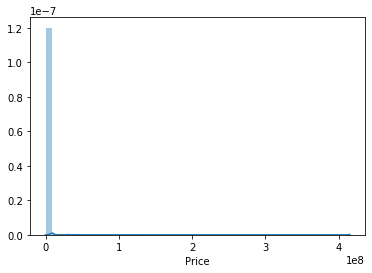

In [29]:
sns.distplot(house_df[house_df['Price'].notnull()]['Price'])

In [28]:
house_df[house_df['Price'].notnull()]['Price']

0        2278000.000
1         684900.000
2        1098000.000
3        1975000.000
4        1350000.000
5         468000.000
6         820000.000
7         695000.000
8        1499000.000
9         859000.000
10        728000.000
11        949900.000
12        299999.000
13        180000.000
14       1379999.000
15       1040000.000
16       1399900.000
17       1898000.000
18        799900.000
19        959000.000
20       4250000.000
21        785000.000
22        639000.000
23       2985000.000
25       2100000.000
27       1699000.000
28       1800000.000
29        235000.000
30        235000.000
31        235000.000
32        235000.000
33        235000.000
34        235000.000
35        369900.000
36        369900.000
37        369900.000
38        369900.000
39        369900.000
40        369900.000
41        645000.000
42        619900.000
43        779900.000
44       1680000.000
46        779000.000
47        314900.000
48        555000.000
49       1549000.000
50        560